In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

We consider missiles with only 1 stage

In [6]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [7]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

# 0. Only one param - m0

In [8]:
m0_param_1 = 'fuelmass'
m0_domain_param_1 = basic_param_spaces[m0_param_1] # [500, 6000] # [5000,15000]

m0_space = ParameterSpace(
          [ContinuousParameter(m0_param_1, *m0_domain_param_1), 
          ])

custom_param_names = [m0_param_1]

In [9]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

fuelmass: 1007.8840088887675


Stage 1 burnout
Velocity (km/s):  0.6978016112431643
Angle (deg h):  43.69724960661012
Range (km):  3.6927765908978962
Time (sec):  24.800000000000086
Final results: 
Range (km):  60.11879127124692
Apogee (km):  19.01539535261587
Time to target (sec):  136.9999999999965




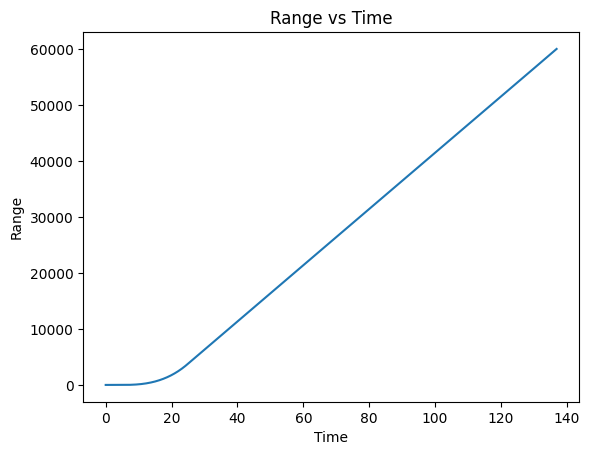

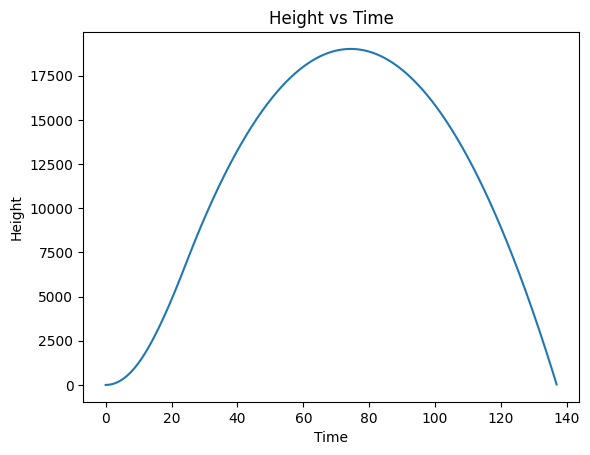

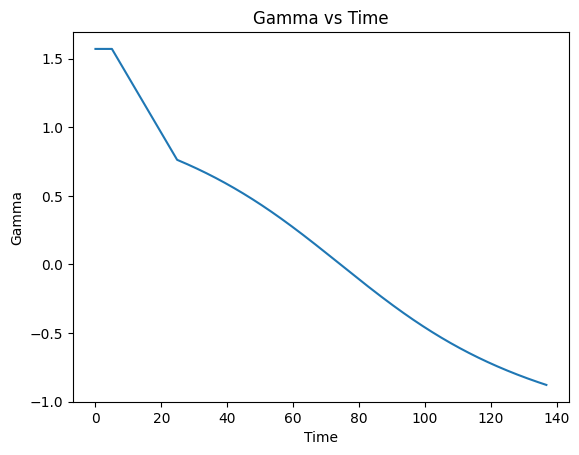

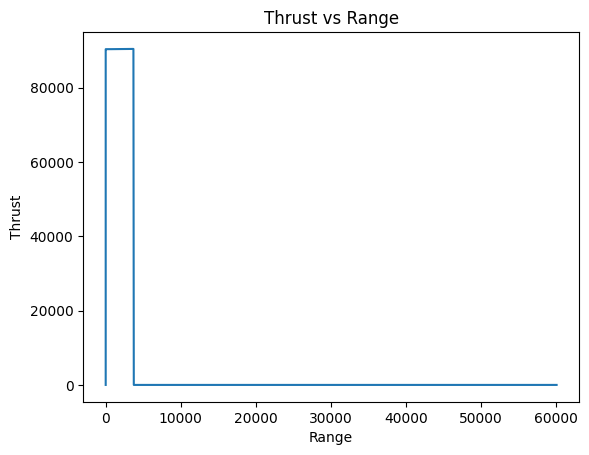

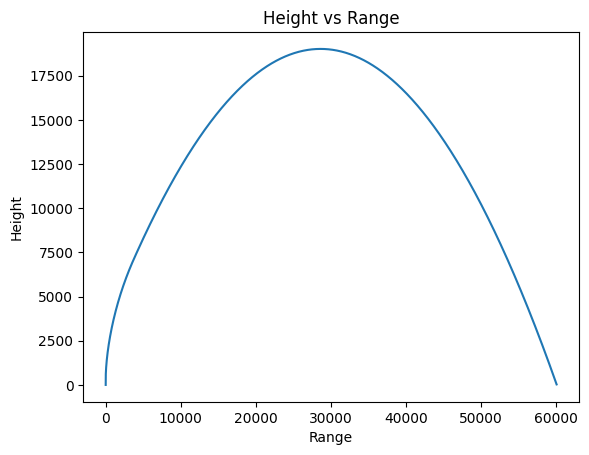

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4113.2114793652045


Stage 1 burnout
Velocity (km/s):  1.7930023621327982
Angle (deg h):  43.673294728018924
Range (km):  31.900601741935937
Time (sec):  101.29999999999852
Final results: 
Range (km):  416.4717608333348
Apogee (km):  131.7242674622094
Time to target (sec):  404.40000000002345




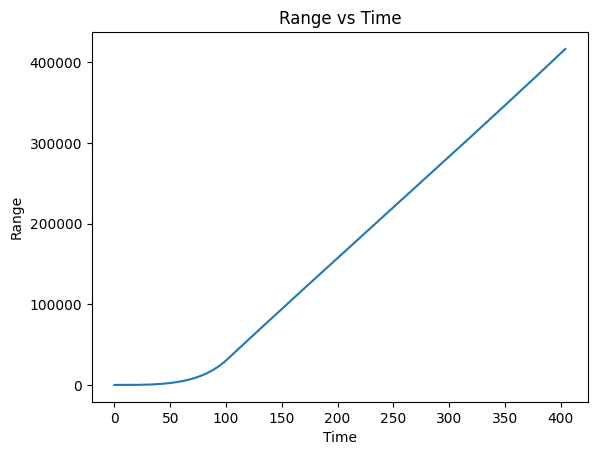

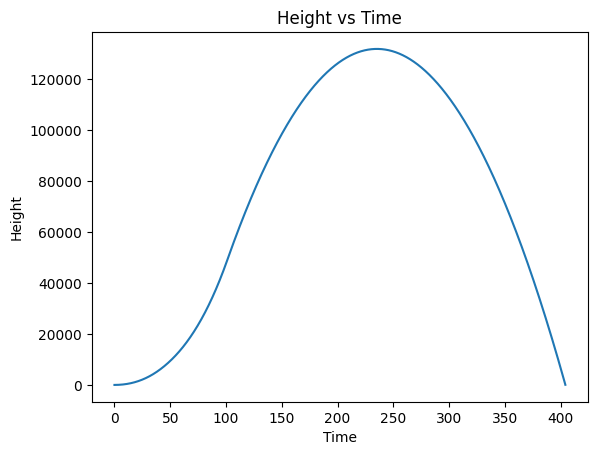

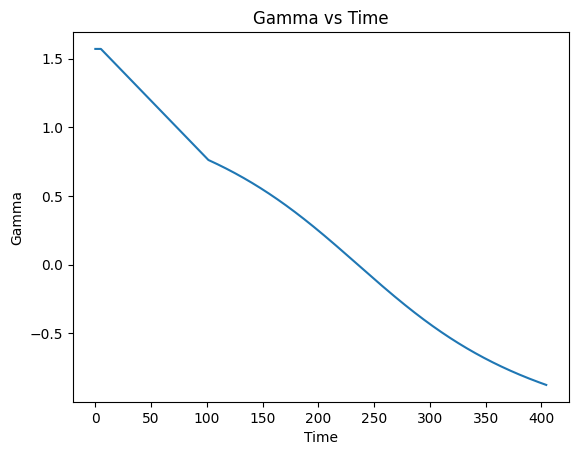

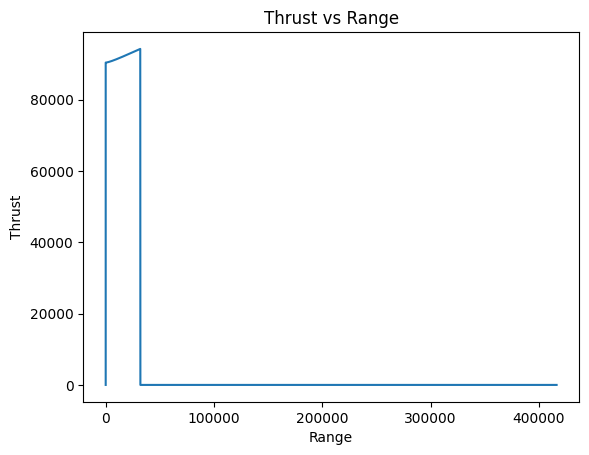

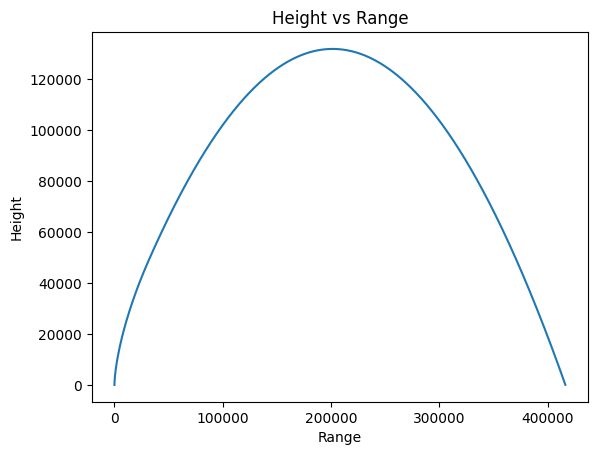

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 849.9309768862413


Stage 1 burnout
Velocity (km/s):  0.6221936524437466
Angle (deg h):  43.67346391307597
Range (km):  2.758683030930767
Time (sec):  21.000000000000032
Final results: 
Range (km):  47.42350449217844
Apogee (km):  14.926926793285853
Time to target (sec):  120.49999999999743




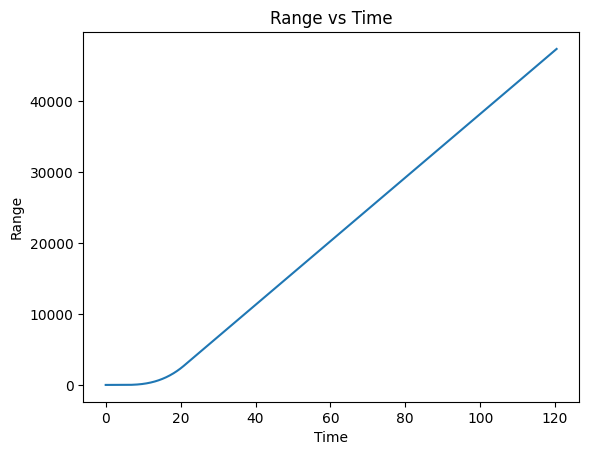

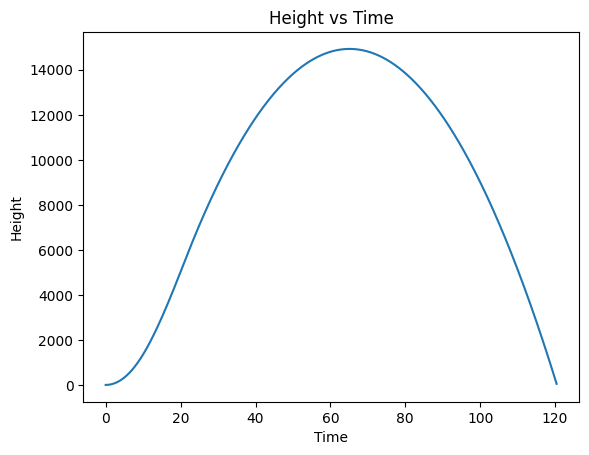

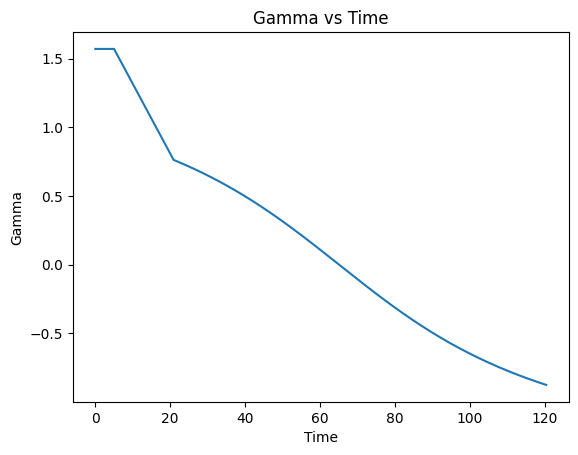

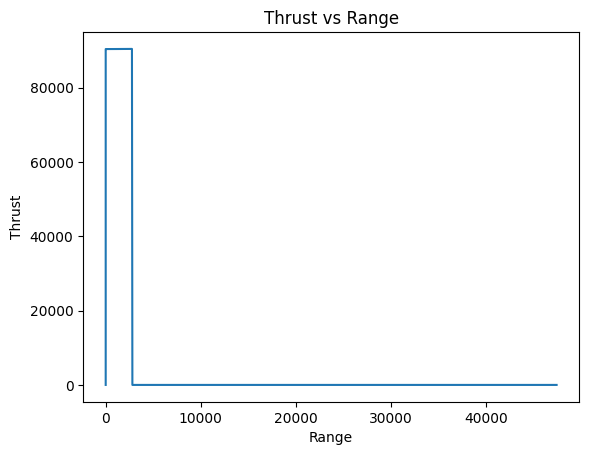

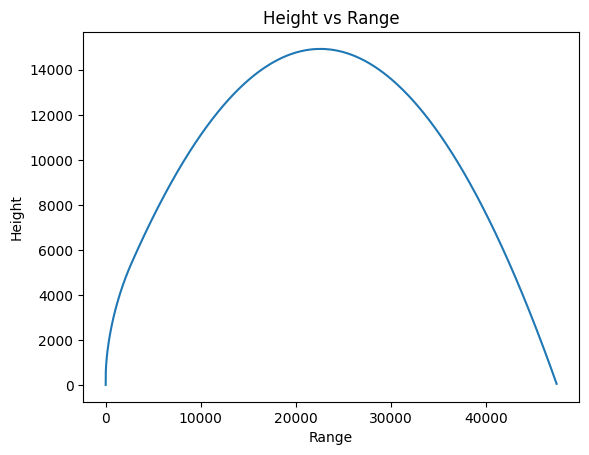

Data written to 'results/results_2.txt'


In [10]:
# Get true points (to build model)
wirte_output_txt = True

m0_design = RandomDesign(m0_space)
m0_x = m0_design.get_samples(3)
m0_y = run_missile_sim(m0_x)

In [11]:
# Build model
m0_var_kernel = (100)**2 
m0_lengthscale = 100 # 1
m0_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m0_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)


constrain_lengthscale = False

m0_rbf_kern = GPy.kern.RBF(input_dim=1, lengthscale=m0_lengthscale)
if constrain_lengthscale:
    m0_rbf_kern.lengthscale.constrain_bounded(m0_lengthscale, m0_lengthscale*1e12)

m0_kern = m0_rbf_kern + \
    GPy.kern.Linear(input_dim=1)


m0_model_gpy = GPRegression(m0_x,m0_y, kernel=m0_kern)
m0_model_gpy.kern.variance =  m0_var_kernel 
m0_model_gpy.likelihood.variance.fix(m0_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m0_model_gpy)



GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,+ve,
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [12]:
# Fit emulator
m0_model_emukit = GPyModelWrapper(m0_model_gpy)
m0_model_emukit.optimize() # Optimize model hyperparameters



In [13]:
display(m0_model_gpy)

GP_regression.,value,constraints,priors
sum.rbf.variance,1260.5367655995387,+ve,
sum.rbf.lengthscale,1442.5283555121175,+ve,
sum.linear.variances,0.009674659779404073,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [14]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m0_param_1_x_plot = np.linspace(m0_space.parameters[0].min, m0_space.parameters[0].max, nr_points_plot)[:, None]
m0_param_1_y_plot = run_missile_sim(m0_param_1_x_plot)




New simulation 

fuelmass: 500.0


Stage 1 burnout
Velocity (km/s):  0.4265056287972526
Angle (deg h):  43.732284489193205
Range (km):  0.9440400159604505
Time (sec):  12.299999999999974
Final results: 
Range (km):  21.661219962904816
Apogee (km):  6.737492515662497
Time to target (sec):  79.59999999999975



New simulation 

fuelmass: 518.3333333333334


Stage 1 burnout
Velocity (km/s):  0.43905877485586203
Angle (deg h):  43.94232680213815
Range (km):  1.037682082180261
Time (sec):  12.799999999999972
Final results: 
Range (km):  23.013791615632808
Apogee (km):  7.19665589314658
Time to target (sec):  82.3999999999996



New simulation 

fuelmass: 536.6666666666666


Stage 1 burnout
Velocity (km/s):  0.44799024767022866
Angle (deg h):  43.73993108354109
Range (km):  1.1013774296045882
Time (sec):  13.19999999999997
Final results: 
Range (km):  24.02034604907838
Apogee (km):  7.485179947127214
Time to target (sec):  84.0999999999995



New simulation 

fuelmass: 555.0


Stage 1 burno

Final results: 
Range (km):  62.247940528556676
Apogee (km):  19.684197662609044
Time to target (sec):  139.49999999999636



New simulation 

fuelmass: 1050.0


Stage 1 burnout
Velocity (km/s):  0.7202978297739892
Angle (deg h):  43.721497967193734
Range (km):  4.000609855124675
Time (sec):  25.9000000000001
Final results: 
Range (km):  64.18088861270505
Apogee (km):  20.309275138239624
Time to target (sec):  141.89999999999623



New simulation 

fuelmass: 1068.3333333333333


Stage 1 burnout
Velocity (km/s):  0.727200175156778
Angle (deg h):  43.66922481111436
Range (km):  4.095587026345635
Time (sec):  26.300000000000107
Final results: 
Range (km):  65.47851793270273
Apogee (km):  20.71032911508845
Time to target (sec):  143.39999999999614



New simulation 

fuelmass: 1086.6666666666665


Stage 1 burnout
Velocity (km/s):  0.7376295471833686
Angle (deg h):  43.72386243762432
Range (km):  4.244312578447072
Time (sec):  26.800000000000114
Final results: 
Range (km):  67.4000630415697

Final results: 
Range (km):  108.2379278531879
Apogee (km):  34.37507899459303
Time to target (sec):  188.0999999999936



New simulation 

fuelmass: 1526.6666666666665


Stage 1 burnout
Velocity (km/s):  0.9354818145600814
Angle (deg h):  43.7435343571224
Range (km):  7.480346939881868
Time (sec):  37.600000000000264
Final results: 
Range (km):  109.74544839927816
Apogee (km):  34.91517355253066
Time to target (sec):  189.7999999999935



New simulation 

fuelmass: 1545.0


Stage 1 burnout
Velocity (km/s):  0.9453253037047598
Angle (deg h):  43.67403376737642
Range (km):  7.660445277125126
Time (sec):  38.10000000000027
Final results: 
Range (km):  112.06117398697565
Apogee (km):  35.5910705830915
Time to target (sec):  191.6999999999934



New simulation 

fuelmass: 1563.3333333333333


Stage 1 burnout
Velocity (km/s):  0.9512920714418213
Angle (deg h):  43.74469408843027
Range (km):  7.773111429055287
Time (sec):  38.50000000000028
Final results: 
Range (km):  113.51926169943863
Apo

Final results: 
Range (km):  167.89101633915632
Apogee (km):  53.213252244401765
Time to target (sec):  238.9999999999907



New simulation 

fuelmass: 2058.333333333333


Stage 1 burnout
Velocity (km/s):  1.1578107095763934
Angle (deg h):  43.705817014986856
Range (km):  12.039898663234686
Time (sec):  50.70000000000045
Final results: 
Range (km):  169.39903808691804
Apogee (km):  53.7981944904769
Time to target (sec):  240.39999999999063



New simulation 

fuelmass: 2076.6666666666665


Stage 1 burnout
Velocity (km/s):  1.1672797394362113
Angle (deg h):  43.656459986351436
Range (km):  12.247090102357344
Time (sec):  51.20000000000046
Final results: 
Range (km):  172.25860590871528
Apogee (km):  54.592948563059984
Time to target (sec):  242.3999999999905



New simulation 

fuelmass: 2095.0


Stage 1 burnout
Velocity (km/s):  1.172472664996571
Angle (deg h):  43.707469135347104
Range (km):  12.370655544371646
Time (sec):  51.60000000000046
Final results: 
Range (km):  173.7808073038

Final results: 
Range (km):  231.524609210653
Apogee (km):  73.21002251930013
Time to target (sec):  285.59999999999644



New simulation 

fuelmass: 2571.6666666666665


Stage 1 burnout
Velocity (km/s):  1.3591656884941619
Angle (deg h):  43.645112674786354
Range (km):  16.928796145574488
Time (sec):  63.40000000000063
Final results: 
Range (km):  234.63391450051816
Apogee (km):  74.07771182967626
Time to target (sec):  287.4999999999969



New simulation 

fuelmass: 2590.0


Stage 1 burnout
Velocity (km/s):  1.3634430988816153
Angle (deg h):  43.68563833331169
Range (km):  17.056274215362418
Time (sec):  63.80000000000064
Final results: 
Range (km):  236.1539731468221
Apogee (km):  74.66442151243628
Time to target (sec):  288.79999999999717



New simulation 

fuelmass: 2608.333333333333


Stage 1 burnout
Velocity (km/s):  1.3722716378343327
Angle (deg h):  43.647361196663134
Range (km):  17.282352259105977
Time (sec):  64.30000000000062
Final results: 
Range (km):  239.2804022760628

Final results: 
Range (km):  298.6870178643473
Apogee (km):  94.28526773777205
Time to target (sec):  330.2000000000066



New simulation 

fuelmass: 3103.333333333333


Stage 1 burnout
Velocity (km/s):  1.5369182110328798
Angle (deg h):  43.639730146960595
Range (km):  22.17056484527043
Time (sec):  76.49999999999993
Final results: 
Range (km):  301.88114592635156
Apogee (km):  95.16669618460175
Time to target (sec):  332.000000000007



New simulation 

fuelmass: 3121.6666666666665


Stage 1 burnout
Velocity (km/s):  1.5400510591705938
Angle (deg h):  43.67290493780263
Range (km):  22.295151899849323
Time (sec):  76.8999999999999
Final results: 
Range (km):  303.1632094467732
Apogee (km):  95.70091818562662
Time to target (sec):  333.10000000000724



New simulation 

fuelmass: 3140.0


Stage 1 burnout
Velocity (km/s):  1.5478789857522226
Angle (deg h):  43.641637394674596
Range (km):  22.530665692146275
Time (sec):  77.39999999999988
Final results: 
Range (km):  306.365932848597
Apo

Final results: 
Range (km):  359.26341228595754
Apogee (km):  113.47423912092366
Time to target (sec):  368.70000000001534



New simulation 

fuelmass: 3616.6666666666665


Stage 1 burnout
Velocity (km/s):  1.6781606126689854
Angle (deg h):  43.662680719462315
Range (km):  27.181912415409663
Time (sec):  89.09999999999921
Final results: 
Range (km):  362.3601494182543
Apogee (km):  114.4221983133505
Time to target (sec):  370.50000000001575



New simulation 

fuelmass: 3635.0


Stage 1 burnout
Velocity (km/s):  1.6803407260438015
Angle (deg h):  43.65873562355769
Range (km):  27.298394095929936
Time (sec):  89.49999999999919
Final results: 
Range (km):  363.5133497346289
Apogee (km):  114.7999293872533
Time to target (sec):  371.40000000001595



New simulation 

fuelmass: 3653.333333333333


Stage 1 burnout
Velocity (km/s):  1.6872976081495372
Angle (deg h):  43.66405677557639
Range (km):  27.535536806523464
Time (sec):  89.99999999999916
Final results: 
Range (km):  366.49282039511

Final results: 
Range (km):  413.37219901644056
Apogee (km):  130.6194974645973
Time to target (sec):  402.20000000002295



New simulation 

fuelmass: 4093.333333333333


Stage 1 burnout
Velocity (km/s):  1.7882112767272529
Angle (deg h):  43.65140749759764
Range (km):  31.700863134337204
Time (sec):  100.79999999999855
Final results: 
Range (km):  414.1696781178146
Apogee (km):  130.9280695541935
Time to target (sec):  402.9000000000231



New simulation 

fuelmass: 4111.666666666666


Stage 1 burnout
Velocity (km/s):  1.794524701941269
Angle (deg h):  43.655006990743566
Range (km):  31.93513965002722
Time (sec):  101.29999999999852
Final results: 
Range (km):  417.1970933485121
Apogee (km):  131.84393694017655
Time to target (sec):  404.6000000000235



New simulation 

fuelmass: 4130.0


Stage 1 burnout
Velocity (km/s):  1.7959332186793822
Angle (deg h):  43.65281229891438
Range (km):  32.040296537663664
Time (sec):  101.6999999999985
Final results: 
Range (km):  417.98286112023874

Final results: 
Range (km):  460.4349697816237
Apogee (km):  145.79543459569646
Time to target (sec):  431.9000000000297



New simulation 

fuelmass: 4570.0


Stage 1 burnout
Velocity (km/s):  1.8858574963205066
Angle (deg h):  43.64782277312238
Range (km):  36.13372800466285
Time (sec):  112.59999999999788
Final results: 
Range (km):  463.3834851223788
Apogee (km):  146.5926210741856
Time to target (sec):  433.40000000003005



New simulation 

fuelmass: 4588.333333333333


Stage 1 burnout
Velocity (km/s):  1.8866389040153642
Angle (deg h):  43.669860489567604
Range (km):  36.226092621395445
Time (sec):  112.99999999999785
Final results: 
Range (km):  463.8752658444878
Apogee (km):  146.89416590865628
Time to target (sec):  434.1000000000302



New simulation 

fuelmass: 4606.666666666666


Stage 1 burnout
Velocity (km/s):  1.892337500254363
Angle (deg h):  43.64901880604165
Range (km):  36.45352243898193
Time (sec):  113.49999999999783
Final results: 
Range (km):  466.8246496552403


Stage 1 burnout
Velocity (km/s):  1.9632877430249627
Angle (deg h):  43.66193706613539
Range (km):  40.144968981491566
Time (sec):  124.29999999999721
Final results: 
Range (km):  505.0244261864955
Apogee (km):  160.0313264020453
Time to target (sec):  460.4000000000362



New simulation 

fuelmass: 5065.0


Stage 1 burnout
Velocity (km/s):  1.9684744184335623
Angle (deg h):  43.64308943673445
Range (km):  40.363095034196355
Time (sec):  124.79999999999718
Final results: 
Range (km):  507.8083215136219
Apogee (km):  160.77965914702668
Time to target (sec):  461.8000000000365



New simulation 

fuelmass: 5083.333333333333


Stage 1 burnout
Velocity (km/s):  1.9686620241422974
Angle (deg h):  43.662906609491465
Range (km):  40.43964556399911
Time (sec):  125.19999999999716
Final results: 
Range (km):  508.0383429025086
Apogee (km):  160.99100112624214
Time to target (sec):  462.40000000003664



New simulation 

fuelmass: 5101.666666666666


Stage 1 burnout
Velocity (km/s):  1.973810126

Final results: 
Range (km):  548.5617069198099
Apogee (km):  173.9424144808009
Time to target (sec):  489.70000000004285



New simulation 

fuelmass: 5633.333333333333


Stage 1 burnout
Velocity (km/s):  2.045041295819789
Angle (deg h):  43.641225187636906
Range (km):  44.739639490741155
Time (sec):  138.7999999999964
Final results: 
Range (km):  551.1427418066775
Apogee (km):  174.6251941017791
Time to target (sec):  491.00000000004314



New simulation 

fuelmass: 5651.666666666666


Stage 1 burnout
Velocity (km/s):  2.0446199029197434
Angle (deg h):  43.658977824909734
Range (km):  44.79589442265172
Time (sec):  139.19999999999638
Final results: 
Range (km):  551.083972154244
Apogee (km):  174.7291286589076
Time to target (sec):  491.50000000004326



New simulation 

fuelmass: 5670.0


Stage 1 burnout
Velocity (km/s):  2.0492036829415374
Angle (deg h):  43.642224962432536
Range (km):  44.998019595551426
Time (sec):  139.69999999999635
Final results: 
Range (km):  553.6587851104707

In [15]:
# Get model prediction on param_1_x_plot
m0_mu_plot, m0_var_plot = m0_model_emukit.predict(m0_param_1_x_plot)



In [16]:
# Plot
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

RMSE m0 (pre experiment design loop):  7.175915276215401


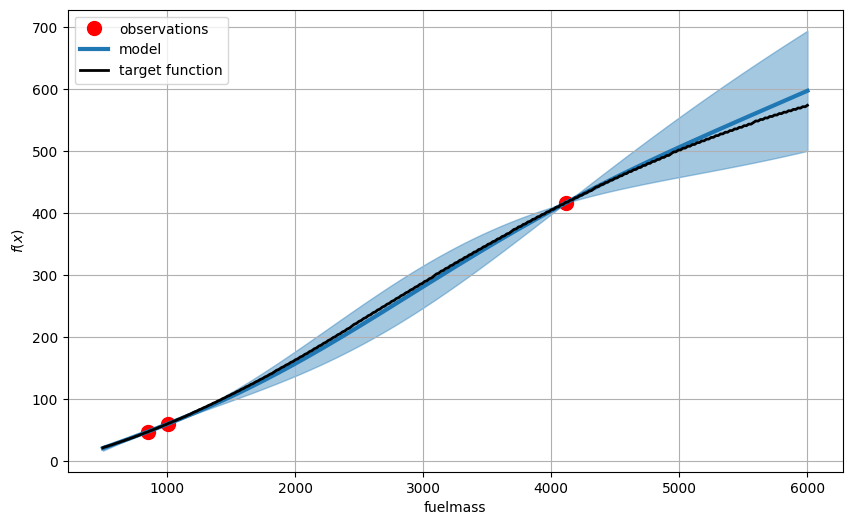

In [17]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m0_param_1_x_plot, y_plot=m0_param_1_y_plot, 
                               mu_plot=m0_mu_plot, var_plot=m0_var_plot, 
                               model_emukit=m0_model_emukit)

m0_rmse = evaluate_prediction(y_actual=m0_param_1_y_plot, y_predicted=m0_mu_plot)
print("RMSE m0 (pre experiment design loop): ", m0_rmse)

### Experiment design loop

In [18]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

In [19]:
m0_2_model_emukit = m0_model_emukit

In [20]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m0_space,
                                                  model=m0_2_model_emukit)
m0_ed = ExperimentalDesignLoop(space=m0_space, 
                            model=m0_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m0_ed.run_loop(user_function=run_missile_sim, stopping_condition=5)



 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 5336.286633499005


Stage 1 burnout
Velocity (km/s):  2.0031498796355165
Angle (deg h):  43.65441827225012
Range (km):  42.40099812276978
Time (sec):  131.39999999999682
Final results: 
Range (km):  527.3657480797298
Apogee (km):  167.1947200518729
Time to target (sec):  475.4000000000396



New simulation 

fuelmass: 2870.056178551053


Stage 1 burnout
Velocity (km/s):  1.4603312433832933
Angle (deg h):  43.67861432087781
Range (km):  19.80304752155
Time (sec):  70.70000000000026
Final results: 
Range (km):  271.76080359339636
Apogee (km):  85.81808126129849
Time to target (sec):  312.7000000000026



New simulation 

fuelmass: 5437.440730935407


Stage 1 burnout
Velocity (km/s):  2.016959034014756
Angle (deg h):  43.65110927817635
Range (km):  43.185262500067815
Time (sec):  133.89999999999668
Final results: 
Range (km):  535.1532002014948
Apogee (km):  169.6705625053785
Time to target (sec):  480.6000000000408



New simulation 

fuelmass: 2436.3189920765

In [21]:
m0_2_mu_plot, m0_2_var_plot = m0_2_model_emukit.predict(m0_param_1_x_plot)



RMSE m0 (post experiment design loop):  1.0654800808660763


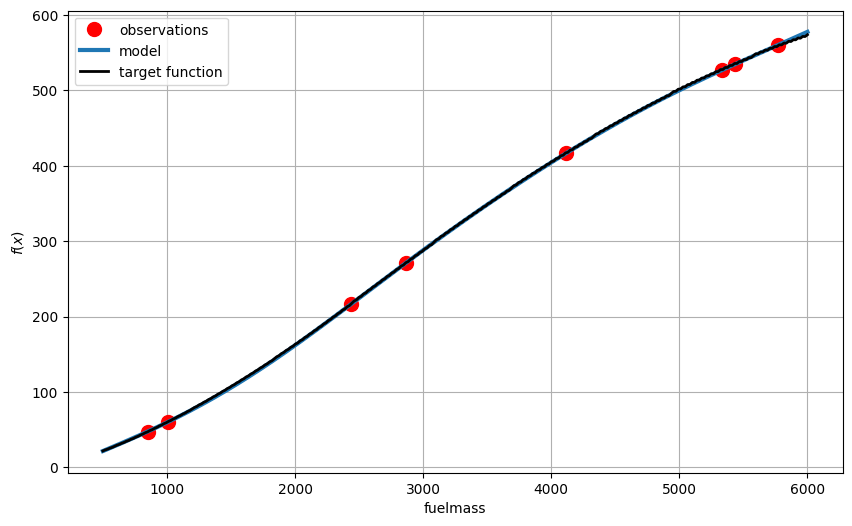

In [22]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m0_param_1_x_plot, y_plot=m0_param_1_y_plot, 
                               mu_plot=m0_2_mu_plot, var_plot=m0_2_var_plot, 
                               model_emukit=m0_2_model_emukit)

m0_2_rmse = evaluate_prediction(y_actual=m0_param_1_y_plot, y_predicted=m0_2_mu_plot)
print("RMSE m0 (post experiment design loop): ", m0_2_rmse)

# 0. Only one param - m1

In [23]:
m1_param_1 = 'Isp0'
m1_domain_param_1 = basic_param_spaces[m1_param_1] # [500, 6000] # [5000,15000]

m1_space = ParameterSpace(
          [ContinuousParameter(m1_param_1, *m1_domain_param_1), 
          ])

custom_param_names = [m1_param_1]

In [24]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

Isp0: 632.4850588045783


Stage 1 burnout
Velocity (km/s):  6.951986958952771
Angle (deg h):  43.65479851742443
Range (km):  406.2582827315758
Time (sec):  386.00000000001927
Final results: 
Range (km):  9287.467919626113
Apogee (km):  3911.6038081153692
Time to target (sec):  3538.899999997877




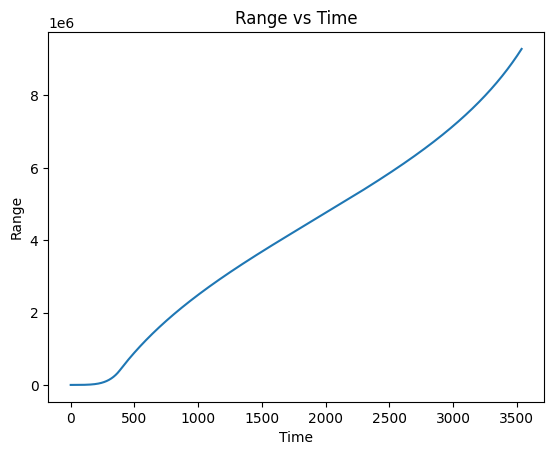

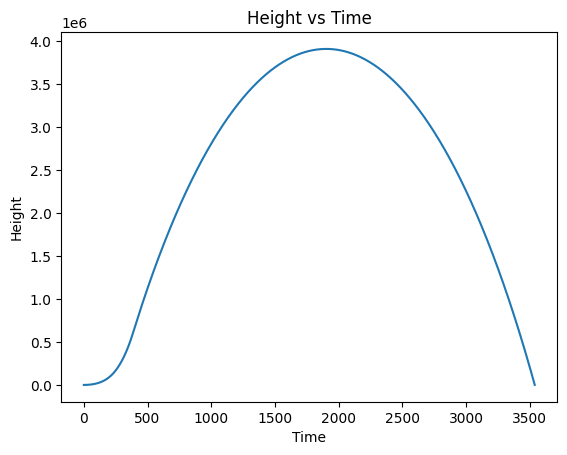

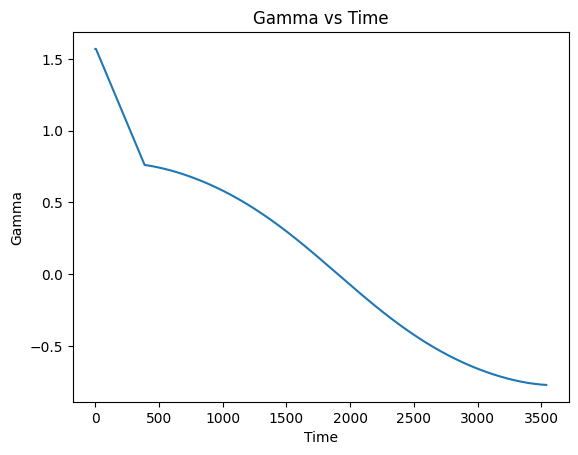

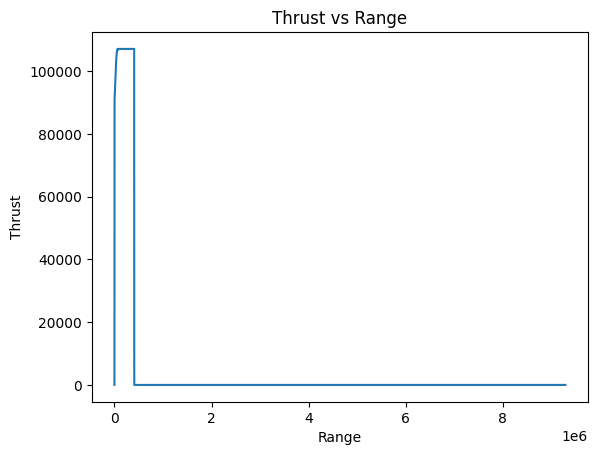

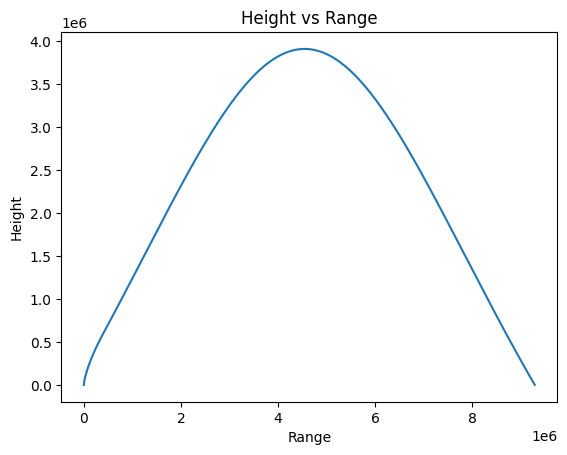

Data written to 'results/results_0.txt'

New simulation 

Isp0: 261.652194637604


Stage 1 burnout
Velocity (km/s):  2.4293213942317604
Angle (deg h):  43.653675344881215
Range (km):  60.73458609084893
Time (sec):  159.6999999999952
Final results: 
Range (km):  784.223400078734
Apogee (km):  247.42768830021498
Time to target (sec):  588.6000000000653




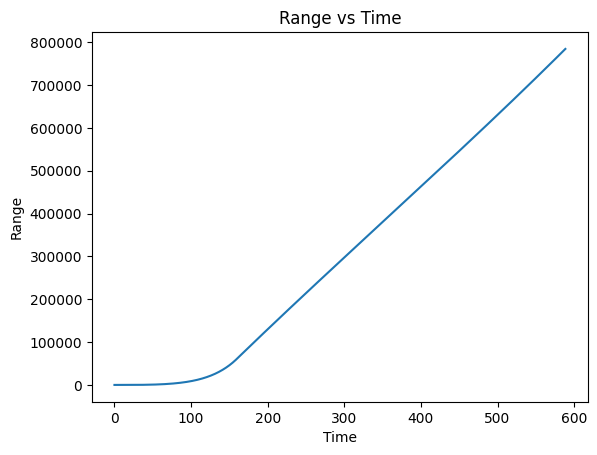

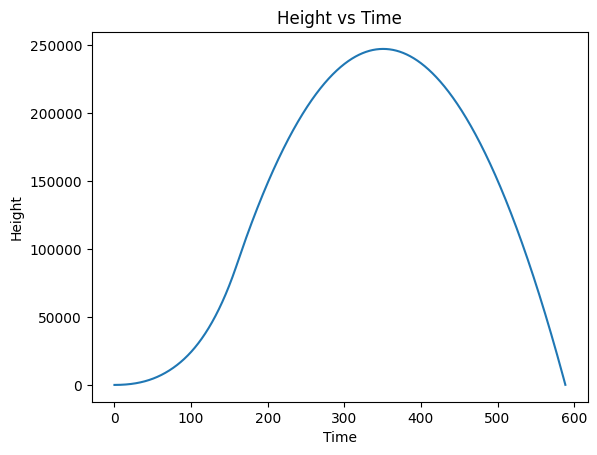

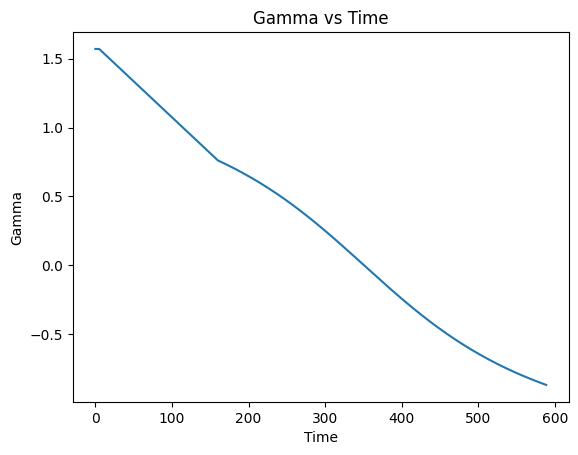

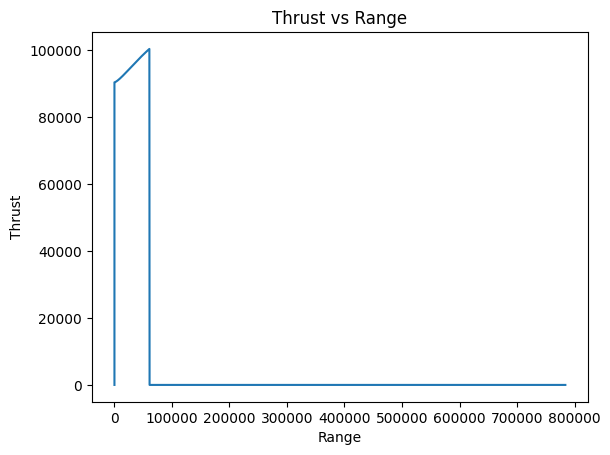

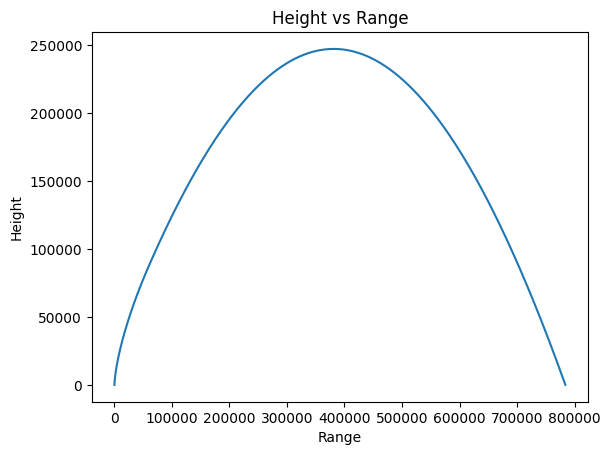

Data written to 'results/results_1.txt'

New simulation 

Isp0: 220.8452126160107


Stage 1 burnout
Velocity (km/s):  1.98477240573621
Angle (deg h):  43.65288429473307
Range (km):  42.32475216111083
Time (sec):  134.79999999999663
Final results: 
Range (km):  518.6145973012602
Apogee (km):  164.50094646411802
Time to target (sec):  475.60000000003964




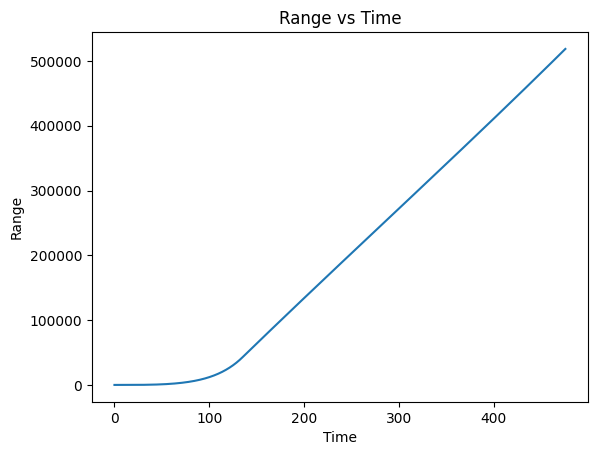

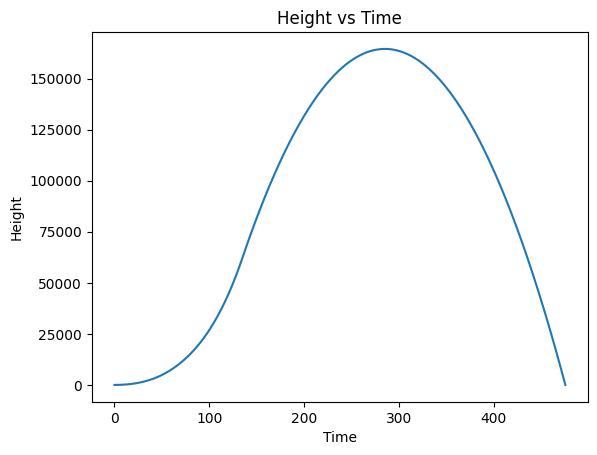

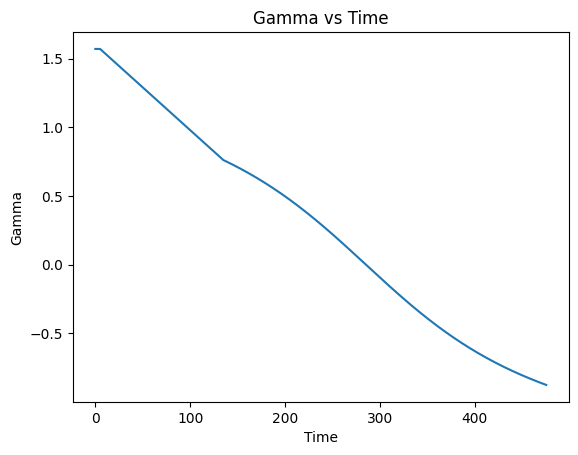

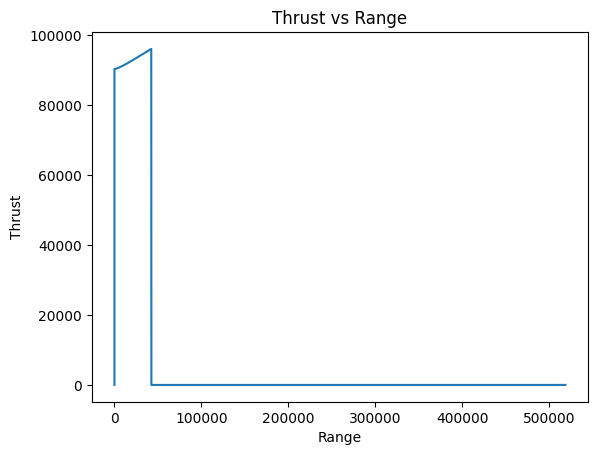

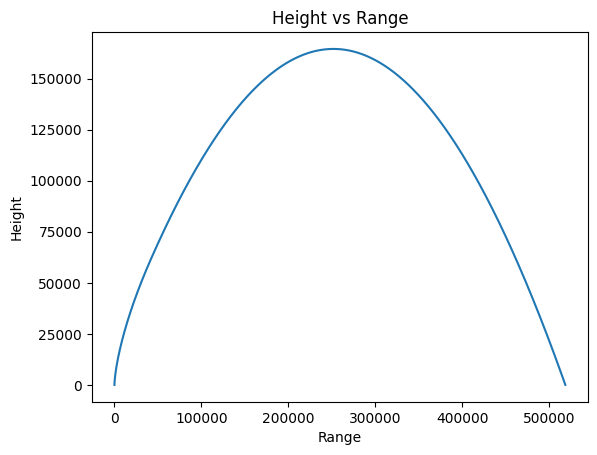

Data written to 'results/results_2.txt'


In [25]:
# Get true points (to build model)
wirte_output_txt = True

m1_design = RandomDesign(m1_space)
m1_x = m1_design.get_samples(3)
m1_y = run_missile_sim(m1_x)

In [26]:
# Build model
m1_var_kernel = (100)**2 
m1_lengthscale = 100 # 1
m1_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m1_var_noise = 1e-5 # small value
# In catapult: 1e-5

constrain_lengthscale = True

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m1_rbf_kern = GPy.kern.RBF(input_dim=1, lengthscale=m1_lengthscale)
if constrain_lengthscale:
    m1_rbf_kern.lengthscale.constrain_bounded(m1_lengthscale, m1_lengthscale*1e12)

m1_kern = m1_rbf_kern + \
    GPy.kern.Linear(input_dim=1)
# m1_kern = m1_rbf_kern 

m1_model_gpy = GPRegression(m1_x,m1_y, kernel=m1_kern)
m1_model_gpy.kern.variance =  m1_var_kernel 
m1_model_gpy.likelihood.variance.fix(m1_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m1_model_gpy)



reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,"100.0,100000000000000.0",
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [27]:
# Fit emulator
m1_model_emukit = GPyModelWrapper(m1_model_gpy)
m1_model_emukit.optimize() # Optimize model hyperparameters



In [28]:
display(m1_model_gpy)

GP_regression.,value,constraints,priors
sum.rbf.variance,4002479.0667978316,+ve,
sum.rbf.lengthscale,100.000000000099,"100.0,100000000000000.0",
sum.linear.variances,159.6930261430499,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [29]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m1_param_1_x_plot = np.linspace(m1_space.parameters[0].min, m1_space.parameters[0].max, nr_points_plot)[:, None]
m1_param_1_y_plot = run_missile_sim(m1_param_1_x_plot)




New simulation 

Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7997108219148806
Angle (deg h):  43.66690727250592
Range (km):  8.174779393074425
Time (sec):  61.0000000000006
Final results: 
Range (km):  84.94191839125949
Apogee (km):  28.119208222477383
Time to target (sec):  194.29999999999325



New simulation 

Isp0: 102.33333333333333


Stage 1 burnout
Velocity (km/s):  0.8221474843630412
Angle (deg h):  43.63686074140344
Range (km):  8.606845607579324
Time (sec):  62.50000000000062
Final results: 
Range (km):  89.67962533097281
Apogee (km):  29.62353712165415
Time to target (sec):  199.39999999999296



New simulation 

Isp0: 104.66666666666667


Stage 1 burnout
Velocity (km/s):  0.8407868820214182
Angle (deg h):  43.65587822679295
Range (km):  8.989919773699633
Time (sec):  63.90000000000064
Final results: 
Range (km):  93.79340960687088
Apogee (km):  30.9819776148128
Time to target (sec):  203.9999999999927



New simulation 

Isp0: 107.0


Stage 1 burnout
Velocity (km/s):

Final results: 
Range (km):  297.91305538859297
Apogee (km):  95.53659286275128
Time to target (sec):  360.1000000000134



New simulation 

Isp0: 177.0


Stage 1 burnout
Velocity (km/s):  1.5299619312154522
Angle (deg h):  43.652806265426406
Range (km):  26.456881209552773
Time (sec):  107.99999999999814
Final results: 
Range (km):  306.9536321642842
Apogee (km):  98.34883291706495
Time to target (sec):  365.5000000000146



New simulation 

Isp0: 179.33333333333334


Stage 1 burnout
Velocity (km/s):  1.5572865016409858
Angle (deg h):  43.638518080616535
Range (km):  27.28296781802165
Time (sec):  109.49999999999805
Final results: 
Range (km):  317.9052472461248
Apogee (km):  101.69414280639275
Time to target (sec):  371.700000000016



New simulation 

Isp0: 181.66666666666669


Stage 1 burnout
Velocity (km/s):  1.5798595164480471
Angle (deg h):  43.649161906110116
Range (km):  28.00920533494776
Time (sec):  110.89999999999797
Final results: 
Range (km):  327.2544211265939
Apogee (km


New simulation 

Isp0: 237.66666666666669


Stage 1 burnout
Velocity (km/s):  2.166258522615286
Angle (deg h):  43.64141118690782
Range (km):  49.52465953762294
Time (sec):  145.09999999999604
Final results: 
Range (km):  619.6768706164804
Apogee (km):  196.01520463571669
Time to target (sec):  520.8000000000499



New simulation 

Isp0: 240.0


Stage 1 burnout
Velocity (km/s):  2.1903415343776325
Angle (deg h):  43.649357309075015
Range (km):  50.52762847338191
Time (sec):  146.49999999999596
Final results: 
Range (km):  633.8652370221943
Apogee (km):  200.5117039225765
Time to target (sec):  527.0000000000513



New simulation 

Isp0: 242.33333333333334


Stage 1 burnout
Velocity (km/s):  2.214515542986998
Angle (deg h):  43.657145785088645
Range (km):  51.54175025292346
Time (sec):  147.89999999999588
Final results: 
Range (km):  648.3803695487097
Apogee (km):  205.08098461115398
Time to target (sec):  533.3000000000527



New simulation 

Isp0: 244.66666666666669


Stage 1 burnout

Stage 1 burnout
Velocity (km/s):  2.938135018179471
Angle (deg h):  43.654066087355744
Range (km):  84.57634858650627
Time (sec):  186.2999999999937
Final results: 
Range (km):  1165.644488483392
Apogee (km):  366.6960523698095
Time to target (sec):  727.0000000000967



New simulation 

Isp0: 307.6666666666667


Stage 1 burnout
Velocity (km/s):  2.970657565901817
Angle (deg h):  43.648791432006085
Range (km):  86.1455339201547
Time (sec):  187.79999999999362
Final results: 
Range (km):  1192.8500641529909
Apogee (km):  375.09123056171507
Time to target (sec):  736.0000000000988



New simulation 

Isp0: 310.0


Stage 1 burnout
Velocity (km/s):  2.997722980383178
Angle (deg h):  43.654851465138414
Range (km):  87.51862462005363
Time (sec):  189.19999999999354
Final results: 
Range (km):  1216.0326312078612
Apogee (km):  382.45023534572783
Time to target (sec):  743.9000000001006



New simulation 

Isp0: 312.33333333333337


Stage 1 burnout
Velocity (km/s):  3.0248543192299215
Angle (d

Final results: 
Range (km):  1905.4123600507392
Apogee (km):  602.3605259483512
Time to target (sec):  961.00000000015



New simulation 

Isp0: 368.33333333333337


Stage 1 burnout
Velocity (km/s):  3.7161301358242067
Angle (deg h):  43.65441740352308
Range (km):  127.50278964413047
Time (sec):  224.7999999999915
Final results: 
Range (km):  1936.92972836053
Apogee (km):  612.782132166712
Time to target (sec):  970.6000000001521



New simulation 

Isp0: 370.6666666666667


Stage 1 burnout
Velocity (km/s):  3.743504667304847
Angle (deg h):  43.65942807698396
Range (km):  129.21313565178866
Time (sec):  226.19999999999143
Final results: 
Range (km):  1968.8538222931759
Apogee (km):  623.3439696556266
Time to target (sec):  980.3000000001543



New simulation 

Isp0: 373.0


Stage 1 burnout
Velocity (km/s):  3.770834171449589
Angle (deg h):  43.65134488199179
Range (km):  130.93564141831078
Time (sec):  227.59999999999135
Final results: 
Range (km):  2001.4122947830003
Apogee (km):  633

Stage 1 burnout
Velocity (km/s):  4.4846132458368455
Angle (deg h):  43.66269916757361
Range (km):  179.76767521654494
Time (sec):  263.19999999999135
Final results: 
Range (km):  2981.2734991087573
Apogee (km):  964.6175765840204
Time to target (sec):  1277.1999999999339



New simulation 

Isp0: 433.6666666666667


Stage 1 burnout
Velocity (km/s):  4.517407695221457
Angle (deg h):  43.64908446585144
Range (km):  182.12444758039467
Time (sec):  264.6999999999917
Final results: 
Range (km):  3033.076024070751
Apogee (km):  982.1241724956013
Time to target (sec):  1291.7999999999206



New simulation 

Isp0: 436.0


Stage 1 burnout
Velocity (km/s):  4.5445151324484945
Angle (deg h):  43.653360657022134
Range (km):  184.18075298695035
Time (sec):  266.099999999992
Final results: 
Range (km):  3076.6874698524443
Apogee (km):  997.5170861251285
Time to target (sec):  1304.599999999909



New simulation 

Isp0: 438.33333333333337


Stage 1 burnout
Velocity (km/s):  4.571619822791908
Angle (

Final results: 
Range (km):  4325.799400104258
Apogee (km):  1455.825990063402
Time to target (sec):  1673.0999999995738



New simulation 

Isp0: 494.33333333333337


Stage 1 burnout
Velocity (km/s):  5.256131062975095
Angle (deg h):  43.65327367472645
Range (km):  241.4638633039229
Time (sec):  301.7000000000001
Final results: 
Range (km):  4394.108746984363
Apogee (km):  1481.982017581963
Time to target (sec):  1693.5999999995552



New simulation 

Isp0: 496.6666666666667


Stage 1 burnout
Velocity (km/s):  5.283244721801929
Angle (deg h):  43.65700138967919
Range (km):  243.82539870422497
Time (sec):  303.1000000000004
Final results: 
Range (km):  4451.8596677521855
Apogee (km):  1504.5411775984146
Time to target (sec):  1711.299999999539



New simulation 

Isp0: 499.0


Stage 1 burnout
Velocity (km/s):  5.310379793419376
Angle (deg h):  43.66069381092142
Range (km):  246.19876808467623
Time (sec):  304.50000000000074
Final results: 
Range (km):  4510.042316421869
Apogee (km):  1

Final results: 
Range (km):  6191.621535634634
Apogee (km):  2234.4796859074486
Time to target (sec):  2273.099999999028



New simulation 

Isp0: 557.3333333333334


Stage 1 burnout
Velocity (km/s):  6.0241322104527315
Angle (deg h):  43.65989985825571
Range (km):  311.5075115416291
Time (sec):  340.10000000000883
Final results: 
Range (km):  6267.021518376941
Apogee (km):  2269.3090252924835
Time to target (sec):  2299.499999999004



New simulation 

Isp0: 559.6666666666667


Stage 1 burnout
Velocity (km/s):  6.051392334158504
Angle (deg h):  43.651574742963994
Range (km):  314.1725014591236
Time (sec):  341.50000000000915
Final results: 
Range (km):  6344.569424341038
Apogee (km):  2304.18084967501
Time to target (sec):  2326.19999999898



New simulation 

Isp0: 562.0


Stage 1 burnout
Velocity (km/s):  6.08437457123056
Angle (deg h):  43.65271866575995
Range (km):  317.25803132449727
Time (sec):  343.0000000000095
Final results: 
Range (km):  6436.955200897575
Apogee (km):  2346.

Final results: 
Range (km):  8625.328886438181
Apogee (km):  3498.5900094789636
Time to target (sec):  3227.8999999981597



New simulation 

Isp0: 620.3333333333334


Stage 1 burnout
Velocity (km/s):  6.802636357006108
Angle (deg h):  43.6528241468581
Range (km):  390.2627146577257
Time (sec):  378.6000000000176
Final results: 
Range (km):  8742.27748219676
Apogee (km):  3568.927338931015
Time to target (sec):  3280.7999999981116



New simulation 

Isp0: 622.6666666666667


Stage 1 burnout
Velocity (km/s):  6.830097075087277
Angle (deg h):  43.65579391387406
Range (km):  393.2171201750222
Time (sec):  380.0000000000179
Final results: 
Range (km):  8840.985877035826
Apogee (km):  3629.5108174837333
Time to target (sec):  3326.39999999807



New simulation 

Isp0: 625.0


Stage 1 burnout
Velocity (km/s):  6.857566352212791
Angle (deg h):  43.6587412957211
Range (km):  396.1815557542571
Time (sec):  381.4000000000182
Final results: 
Range (km):  8940.157231787227
Apogee (km):  3691.3661

Final results: 
Range (km):  11697.476034395966
Apogee (km):  5790.913442909934
Time to target (sec):  4963.800000000527



New simulation 

Isp0: 683.3333333333334


Stage 1 burnout
Velocity (km/s):  7.5817561332566195
Angle (deg h):  43.658366207940595
Range (km):  476.45017221337207
Time (sec):  417.0000000000263
Final results: 
Range (km):  11815.462282880037
Apogee (km):  5903.454166766521
Time to target (sec):  5049.80000000084



New simulation 

Isp0: 685.6666666666667


Stage 1 burnout
Velocity (km/s):  7.609468563779552
Angle (deg h):  43.661042637443714
Range (km):  479.6771760991936
Time (sec):  418.40000000002664
Final results: 
Range (km):  11933.878639295912
Apogee (km):  6018.893198818654
Time to target (sec):  5138.100000001161



New simulation 

Isp0: 688.0


Stage 1 burnout
Velocity (km/s):  7.637189857074844
Angle (deg h):  43.65235788988258
Range (km):  482.91351152162383
Time (sec):  419.80000000002696
Final results: 
Range (km):  12055.457110759555
Apogee (km): 

Final results: 
Range (km):  15191.910265046341
Apogee (km):  10512.005128801015
Time to target (sec):  8686.100000014068



New simulation 

Isp0: 746.3333333333334


Stage 1 burnout
Velocity (km/s):  8.368321787909588
Angle (deg h):  43.65168834572543
Range (km):  570.0389765894906
Time (sec):  455.40000000003505
Final results: 
Range (km):  15322.650464282442
Apogee (km):  10764.769704175966
Time to target (sec):  8893.500000014823



New simulation 

Isp0: 748.6666666666667


Stage 1 burnout
Velocity (km/s):  8.402111882169475
Angle (deg h):  43.655190102290014
Range (km):  574.0578431059074
Time (sec):  456.9000000000354
Final results: 
Range (km):  15473.421445959106
Apogee (km):  11078.655992180176
Time to target (sec):  9151.00000001576



New simulation 

Isp0: 751.0


Stage 1 burnout
Velocity (km/s):  8.430118393547925
Angle (deg h):  43.657642668429126
Range (km):  577.5511544634765
Time (sec):  458.3000000000357
Final results: 
Range (km):  15599.890935193001
Apogee (km):  

In [30]:
# Get model prediction on param_1_x_plot
m1_mu_plot, m1_var_plot = m1_model_emukit.predict(m1_param_1_x_plot)



RMSE m1 (pre experiment design loop):  2495.4252546081


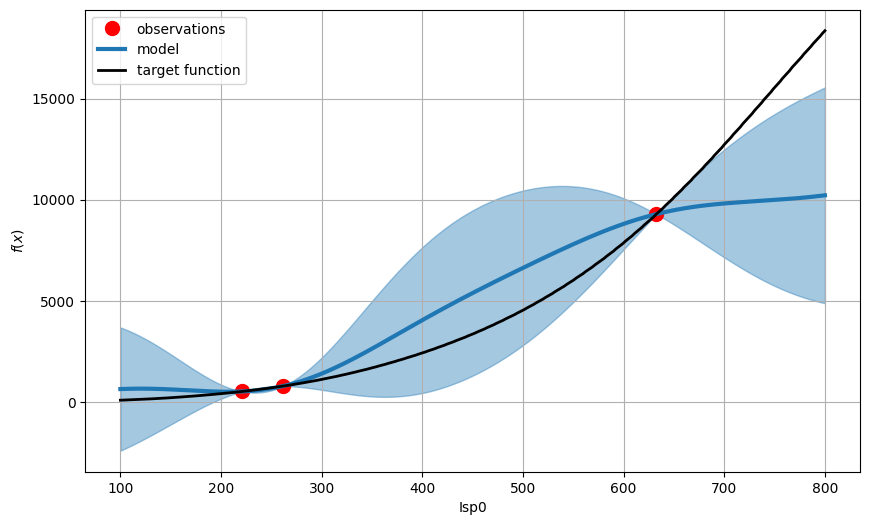

In [31]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m1_param_1_x_plot, y_plot=m1_param_1_y_plot, 
                               mu_plot=m1_mu_plot, var_plot=m1_var_plot, 
                               model_emukit=m1_model_emukit)

m1_rmse = evaluate_prediction(y_actual=m1_param_1_y_plot, y_predicted=m1_mu_plot)
print("RMSE m1 (pre experiment design loop): ", m1_rmse)

### Experiment design loop

In [32]:
m1_2_model_emukit = m1_model_emukit

In [33]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m1_space,
                                                  model=m1_2_model_emukit)
m1_ed = ExperimentalDesignLoop(space=m1_space, 
                            model=m1_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m1_ed.run_loop(user_function=run_missile_sim, stopping_condition=5)



 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

Isp0: 453.8115854906686


Stage 1 burnout
Velocity (km/s):  4.757773066937232
Angle (deg h):  43.65308698446824
Range (km):  200.62970617155497
Time (sec):  276.89999999999446
Final results: 
Range (km):  3435.23616105572
Apogee (km):  1124.8530801502245
Time to target (sec):  1409.099999999814



New simulation 

Isp0: 747.8325958719347


Stage 1 burnout
Velocity (km/s):  8.39211805728013
Angle (deg h):  43.65426424435811
Range (km):  572.8125394418782
Time (sec):  456.4000000000353
Final results: 
Range (km):  15428.140370527834
Apogee (km):  10983.199112700311
Time to target (sec):  9072.500000015474



New simulation 

Isp0: 459.0419390861636


Stage 1 burnout
Velocity (km/s):  4.822031152282082
Angle (deg h):  43.65163411011696
Range (km):  205.6886754418494
Time (sec):  280.0999999999952
Final results: 
Range (km):  3548.962160892317
Apogee (km):  1165.8277895746091
Time to target (sec):  1442.2999999997837



New simulation 

Isp0: 136.0755293944842


Stage 1 b

In [34]:
m1_2_mu_plot, m1_2_var_plot = m1_2_model_emukit.predict(m1_param_1_x_plot)



RMSE m1 (post experiment design loop):  202.81859322929324


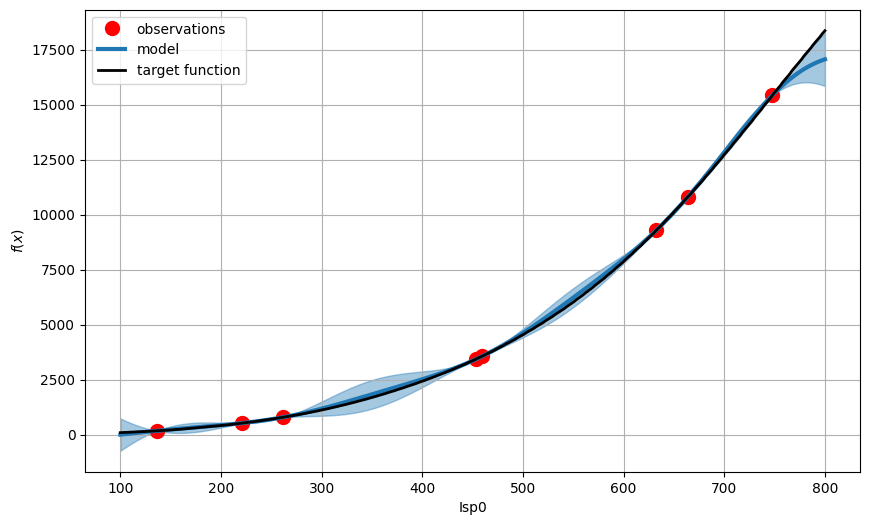

In [35]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m1_param_1_x_plot, y_plot=m1_param_1_y_plot, 
                               mu_plot=m1_2_mu_plot, var_plot=m1_2_var_plot, 
                               model_emukit=m1_2_model_emukit)

m1_2_rmse = evaluate_prediction(y_actual=m1_param_1_y_plot, y_predicted=m1_2_mu_plot)
print("RMSE m1 (post experiment design loop): ", m1_2_rmse)